In [1]:
from os import listdir, system
from sys import argv

import numpy as np


from modules.spline import *
from modules.stats import *
from modules.helper_functions import *
from modules.plot_functions import *

import __main__

In [2]:
executed_as_python = hasattr(__main__, '__file__')
saveimage = False
if executed_as_python:
    import matplotlib
    matplotlib.use('Agg')
    saveimage = True

In [3]:
# Insert Elvis directory here
elvis_iso_dir = "../../Elvis/IsolatedTrees"

# Insert suite name here
suite_name = "iLincoln"
type_suite = "isolated"
halo_row = 0
sub_suite_name = suite_name

# # Insert Elvis directory here
# elvis_iso_dir = "../../Elvis/PairedTrees"

# # Insert suite name here
# suite_name = "Hall&Oates"
# type_suite = "paired"
# halo_row = 1
# sub_suite_name = "Oates"

if executed_as_python:
    suite_name = argv[1]
    halo_row = int(argv[2])
    
    if suite_name.startswith('i'):
        type_suite = 'isolated'
        halo_row = 0
        sub_suite_name = suite_name
    else:
        type_suite = 'paired'
        split = suite_name.split('&')
        sub_suite_name = split[halo_row]
        elvis_iso_dir = "../../Elvis/PairedTrees"

timedata_dir='timedata/'+type_suite

In [4]:
# Do not modify
data = read_elvis_tracks(elvis_iso_dir, suite_name,varnames = ['Mvir','scale','X','Y','Z','ID','pID','Rvir','Vx','Vy','Vz'])


In [5]:
_, lookback_time0, X0, Y0, Z0, Vx0, Vy0, Vz_0, Mvir0, Rvir0, coefs_X0, coefs_Y0, coefs_Z0, coefs_Mvir0, coefs_Rvir0 = extract_data(data, halo_row, isCoefsPos = True, isCoefsMvir = True, isCoefsRvir = True)

In [6]:
plot_pretty()

In [7]:
num_halos = get_num_halos(data)
num_time = get_num_time(data)

In [ ]:
arr_row, arr_time, arr_pos_acc, arr_vec_acc, arr_ang_pos_acc, arr_ang_vec_acc, arr_pos_cur, arr_vec_cur, arr_ang_pos_cur, arr_ang_vec_cur, arr_pos_cur_dis, arr_vec_cur_dis, arr_mass_acc, arr_mass_cur = get_arrays(sub_suite_name, type_suite, data, halo_row)


In [ ]:
title = f"The current velocity distribution of massive subhalos of {sub_suite_name}"
img_name = f"../../result/{type_suite}/{sub_suite_name}/current_velocity_distribution_of_subhalos_of_{sub_suite_name}.pdf"

plot_spherical_coordinates(arr_ang_vec_cur, arr_mass_cur, title, img_name, saveimage = saveimage)


In [ ]:
title = f"The current position distribution of massive subhalos of {sub_suite_name}"
img_name = f"../../result/{type_suite}/{sub_suite_name}/current_position_distribution_of_subhalos_of_{sub_suite_name}.pdf"

plot_spherical_coordinates(arr_ang_pos_cur, arr_mass_cur, title, img_name, saveimage = saveimage)


In [ ]:
title = f"The accretion velocity distribution of massive subhalos of {sub_suite_name}"
img_name = f"../../result/{type_suite}/{sub_suite_name}/accretion_velocity_distribution_of_subhalos_of_{sub_suite_name}.pdf"

plot_spherical_coordinates(arr_ang_vec_acc, arr_mass_acc, title, img_name, arr_time = arr_time, isColorBar = True, saveimage = saveimage)

In [ ]:
title = f"The accretion position distribution of massive subhalos of {sub_suite_name}"
img_name = f"../../result/{type_suite}/{sub_suite_name}/accretion_position_distribution_of_subhalos_of_{sub_suite_name}.pdf"

plot_spherical_coordinates(arr_ang_pos_acc, arr_mass_acc, title, img_name, arr_time = arr_time, isColorBar = True, saveimage = saveimage)

In [ ]:
title = f"Cumulative distribution of $\cos(\\theta)$ of {sub_suite_name}'s subhalos at accretion"
img_name = f"../../result/{type_suite}/{sub_suite_name}/cumulative_angular_distribution_of_{sub_suite_name}.pdf"

plot_kolmogorov(arr_pos_acc, img_name, title=title, saveimage=False)

In [ ]:
if not executed_as_python:
    %matplotlib notebook
    title = f'accretion distribution of subhalos of {sub_suite_name}'
    plot_quiver(arr_pos_acc, arr_vec_acc, title=title, arr_time = arr_time, isColor = True)

In [ ]:
if not executed_as_python:
    %matplotlib notebook
    title = f"current distribution of subhalos of {sub_suite_name}"
    plot_quiver(arr_pos_cur, arr_vec_cur, title=title)

In [ ]:
if not executed_as_python:
    %matplotlib notebook
    title = f"current distribution with distance of subhalos of {sub_suite_name}"
    plot_quiver(arr_pos_cur_dis, arr_vec_cur_dis, title=title)

In [ ]:
if not executed_as_python:
    %matplotlib notebook
    
    title = f"current distribution of subhalos of {sub_suite_name} with poles"
    
    poles = np.cross(arr_pos_cur, arr_vec_cur).T
    temp = (np.sum(poles**2, axis = 0))**(1/2)
    poles = np.array(poles/temp).T
    
    plot_quiver(arr_pos_cur, poles, title=title)

In [ ]:
%matplotlib inline
prop = 'Mass'
label = f"{prop} of {sub_suite_name} halo"
title = f'{prop} evolution of {suite_name} halo'
imgname = f"../../result/{type_suite}/{suite_name}/{prop}_evolution_of_{suite_name}.pdf"
plot_evolution(lookback_time0, coefs_Mvir0, prop, label, title, imgname)

In [ ]:
img_name = f'../../result/{type_suite}/{sub_suite_name}/accretion_animation_of_{sub_suite_name}.gif'
anim = make_animations(data, arr_row, num_time, halo_row, img_name, saveimage=saveimage)

In [ ]:
img_name = f"../../result/{type_suite}/{sub_suite_name}/rms_height_evolution_of_subhalos_of_{sub_suite_name}.pdf"
title = f'rms height evolution of subhalos of {sub_suite_name}'
plot_rms(data, arr_row, lookback_time0, X0, Y0, Z0, Rvir0, title, img_name, saveimage = saveimage)

In [ ]:
imgname = f"../../result/{type_suite}/{sub_suite_name}/distribution_rms_dispersion.pdf"
plot_distribution_rms_dispersion(sub_suite_name, halo_row, imgname, show_isotropy = True, show_uniform = True, ax=None, data=data, timedata_dir='timedata/'+type_suite, saveimage=saveimage)


In [ ]:
imgname=f"../../result/{type_suite}/{sub_suite_name}/distribution_orbital_poles_and_uncertainties_for_{sub_suite_name}.pdf"
plot_orbital_poles(sub_suite_name,halo_row,data,imgname,timedata_dir=timedata_dir,saveimage=saveimage)


In [ ]:
imgname=f"../../result/{type_suite}/{sub_suite_name}/distribution_orbital_poles_and_uncertainties_with_best_config_for_{sub_suite_name}.pdf"
plot_orbital_poles_with_best_config(sub_suite_name, halo_row, data, imgname, timedata_dir=timedata_dir, saveimage=saveimage)


In [ ]:
imgname=f"../../result/{type_suite}/{sub_suite_name}/rms_orbital_poles_vs_k_for_{sub_suite_name}.pdf"
plot_rms_orbital_poles_vs_k(sub_suite_name, halo_row, data, imgname, timedata_dir=timedata_dir, saveimage=saveimage)


In [ ]:
imgname=f"../../result/{type_suite}/{sub_suite_name}/distribution_rms_orbital_poles_dispersion_for_{sub_suite_name}.pdf"
plot_distribution_rms_orbital_poles_dispersion(sub_suite_name, halo_row, data, imgname, timedata_dir=timedata_dir, saveimage=saveimage)


In [ ]:
imgname=f"../../result/{type_suite}/{sub_suite_name}/distribution_rms_orbital_poles_dispersion_with_selection_for_{sub_suite_name}.pdf"
plot_distribution_rms_orbital_poles_dispersion_with_selection(sub_suite_name, halo_row, data, imgname, timedata_dir=timedata_dir, saveimage=saveimage)


/Users/khanhnp/Desktop/NewProject/SatelliteAnisotropy/src/modules/plot_functions.py:62: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls),


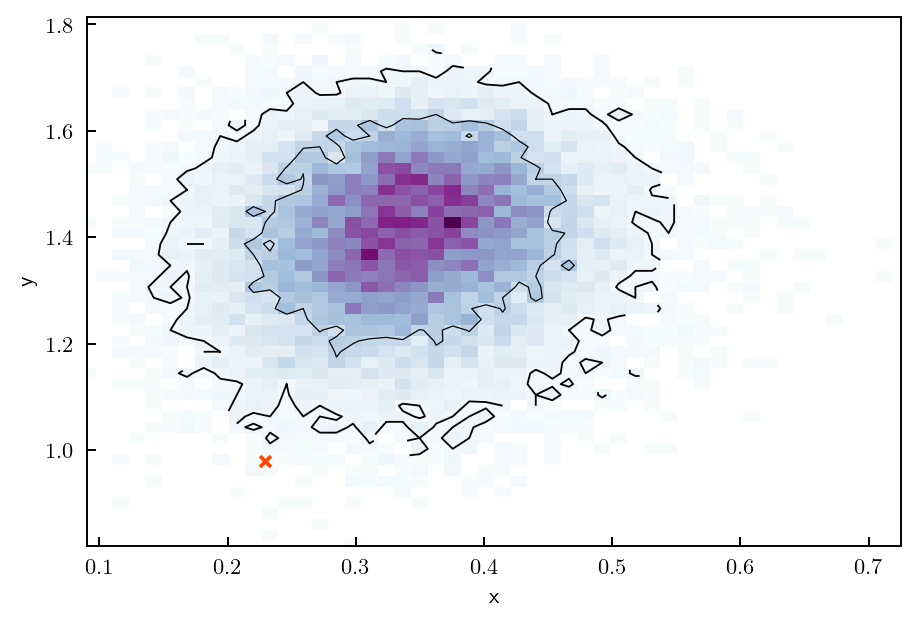

In [8]:
imgname=f"../../result/{type_suite}/{sub_suite_name}/hist_rms_vs_rms_pole_for_{sub_suite_name}.pdf"
plot_hist_rms_vs_rms_poles(sub_suite_name, halo_row, data, imgname, timedata_dir=timedata_dir, saveimage=saveimage)
